# 1. Initial data exploration

Load and inspect the dataset, calculate summary statistics, analyze missing values, create basic visualizations (histograms, boxplots, correlation matrices), and provide demographic overview of the user base.

In [3]:
import pandas as pd
import numpy as np
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling

In [4]:
data = pd.read_parquet('train.parquet', engine = 'pyarrow')

In [5]:
data.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


In [6]:
data.shape

(17499636, 19)

In [7]:
data.dtypes

status                    int64
gender                   object
firstName                object
level                    object
lastName                 object
userId                   object
ts                        int64
auth                     object
page                     object
sessionId                 int64
location                 object
itemInSession             int64
userAgent                object
method                   object
length                  float64
song                     object
artist                   object
time             datetime64[us]
registration     datetime64[us]
dtype: object

Splitting the data to categorical and continuous:

In [8]:
categorical = data.select_dtypes(include=["object", "bool"]).columns.to_list()
data[categorical].nunique()

gender            2
firstName      4967
level             2
lastName       1000
userId        19140
auth              2
page             19
location        875
userAgent        85
method            2
song         239299
artist        37264
dtype: int64

In [9]:
continuous = data.drop(columns=categorical).columns.to_list()
data[continuous].nunique()

status                 3
ts               4189091
sessionId         161194
itemInSession       1427
length             23379
time             4189091
registration       19118
dtype: int64

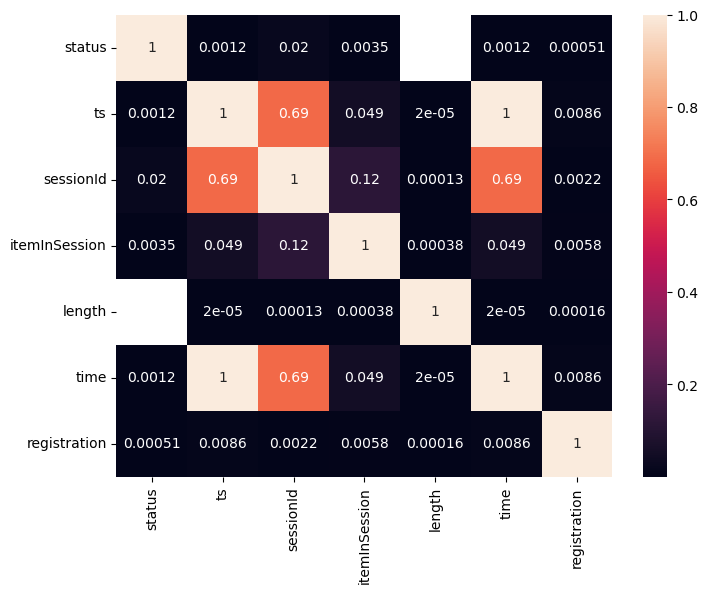

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[continuous].corr().abs(), annot=True);

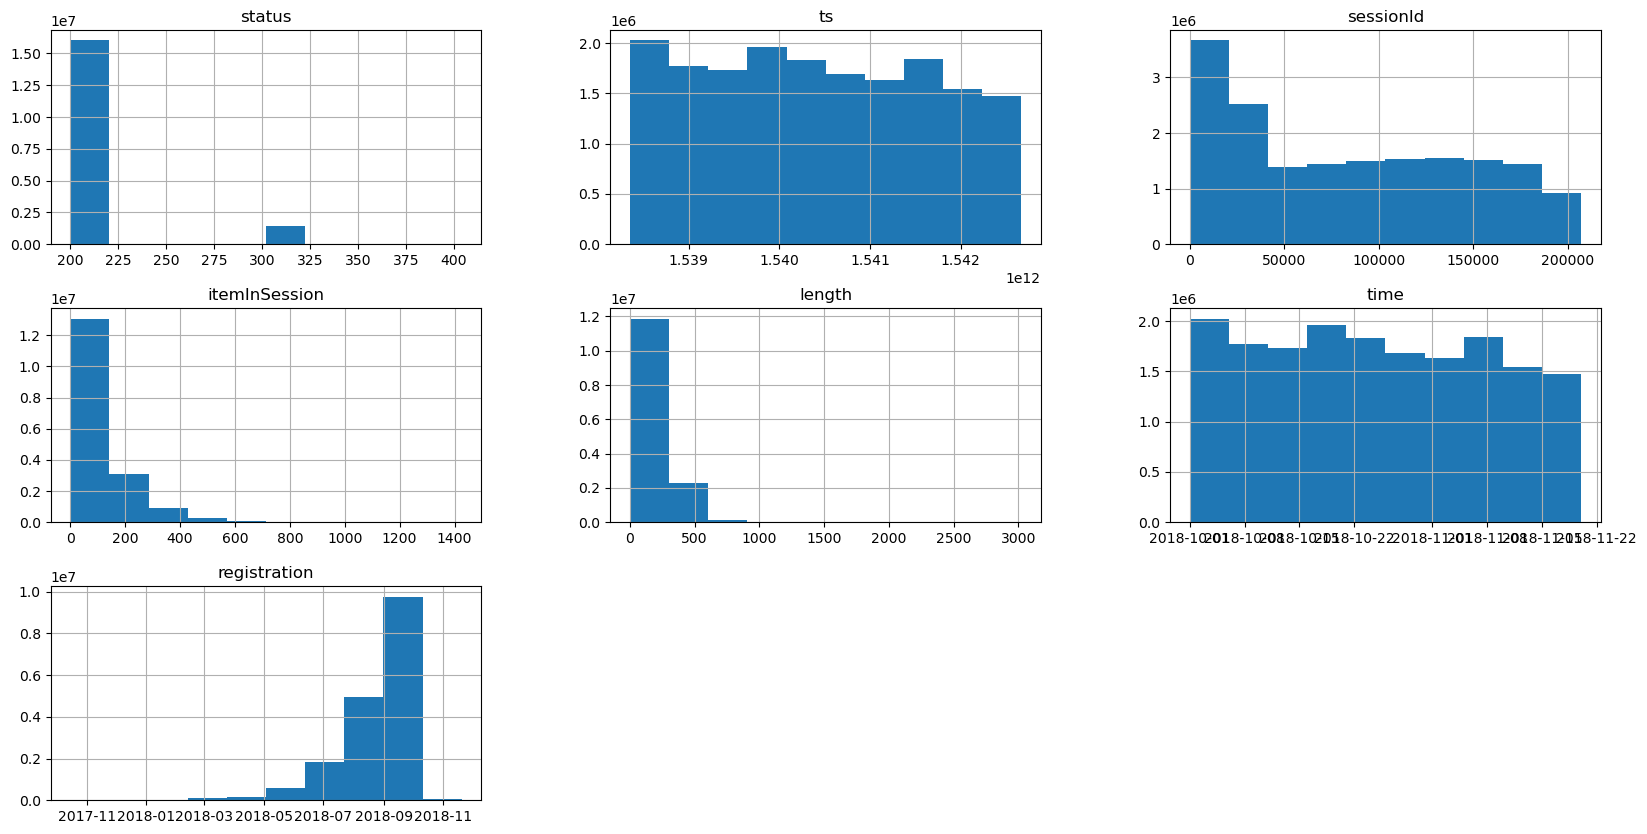

In [11]:
data.hist(figsize=(20, 10));

In [ ]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
data['page'].value_counts()

page
NextSong                     14291433
Thumbs Up                      789391
Home                           645259
Add to Playlist                409606
Roll Advert                    284837
Add Friend                     262147
Logout                         204700
Thumbs Down                    164964
Downgrade                      124248
Settings                       101191
Help                            89035
Upgrade                         37696
About                           33117
Save Settings                   20370
Error                           17294
Submit Upgrade                  11381
Submit Downgrade                 4425
Cancellation Confirmation        4271
Cancel                           4271
Name: count, dtype: int64

If we look at the page `Cancellation Confirmation`, we can see that 4271 users churned. Can a user churn multiple times?

In [13]:
churn_events = data[data['page'] == 'Cancellation Confirmation'][['userId', 'time']]
churn_events = churn_events.rename(columns={'time': 'churn_time'})

In [14]:
all_users = data['userId'].unique()
churned_users = churn_events['userId'].unique()
non_churn_users = [u for u in all_users if u not in churned_users]

In [19]:
churner_ratio = len(churned_users) / len(all_users)
print(f'{round(churner_ratio * 100, 2)} % of users have churned.')

22.31 % of users have churned.


Checking if there are users who have churned multiple times:

In [ ]:
unique_churners = data[data['page'] == 'Cancellation Confirmation']['userId'].unique()
non_unique_churners = data[data['page'] == 'Cancellation Confirmation']['userId']

print(f'Are there users who have churned multiple times? {unique_churners.shape != non_unique_churners.shape}.')

Are there users who have churned multiple times? False.


Now let's check if users used the app AFTER the churn:

In [ ]:
churn_users_data = data[data['userId'].isin(unique_churners)].copy()
churn_users_data = churn_users_data.merge(
    churn_events,
    on='userId',
    how='left'
)
churn_users_data['is_after_churn'] = churn_users_data['time'] > churn_users_data['churn_time']

after_churn = churn_users_data[churn_users_data['is_after_churn']]

print(f'Are there events after churn? {after_churn.shape[0] != 0}.')

Are there events after churn? False.
